<a href="https://colab.research.google.com/github/qhung23125005/AIO/blob/main/AIO24/Module6/AdvancedCNN/WeatherClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries and Set up seed


In [ ]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed (seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

#Data

##Download data

In [ ]:
!gdown 1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0

Downloading...
From (original): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0
From (redirected): https://drive.google.com/uc?id=1fnJMMw0LvDgl-GS4FTou5qAgLxOE2KQ0&confirm=t&uuid=3eba18b7-29eb-4bc4-9420-815593fae15e
To: /content/img_cls_weather_dataset.zip
100% 613M/613M [00:09<00:00, 66.2MB/s]


In [ ]:
!unzip img_cls_weather_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: weather-dataset/dataset/frost/3922.jpg  
  inflating: weather-dataset/dataset/frost/3923.jpg  
  inflating: weather-dataset/dataset/frost/3924.jpg  
  inflating: weather-dataset/dataset/frost/3925.jpg  
  inflating: weather-dataset/dataset/frost/3926.jpg  
  inflating: weather-dataset/dataset/frost/3927.jpg  
  inflating: weather-dataset/dataset/frost/3928.jpg  
  inflating: weather-dataset/dataset/frost/3929.jpg  
  inflating: weather-dataset/dataset/frost/3930.jpg  
  inflating: weather-dataset/dataset/frost/3931.jpg  
  inflating: weather-dataset/dataset/frost/3932.jpg  
  inflating: weather-dataset/dataset/frost/3933.jpg  
  inflating: weather-dataset/dataset/frost/3934.jpg  
  inflating: weather-dataset/dataset/frost/3935.jpg  
  inflating: weather-dataset/dataset/frost/3936.jpg  
  inflating: weather-dataset/dataset/frost/3937.jpg  
  inflating: weather-dataset/dataset/frost/3938.jpg  
  inflating: weather-dataset/da

##Load data

In [ ]:
root_dir = './weather-dataset/dataset'

classes = {
    label_idx: class_name
      for label_idx, class_name in enumerate(
          sorted(os.listdir(root_dir))
      )
}

classes

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

Visualize

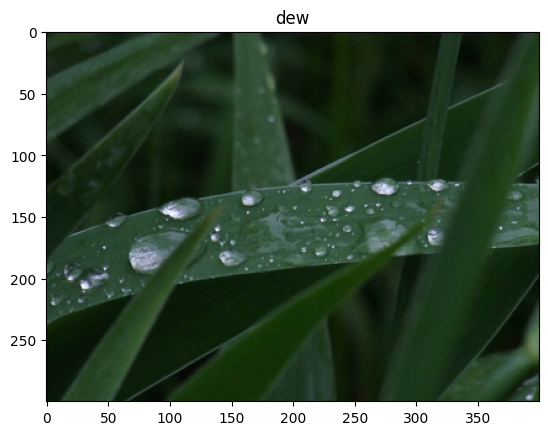

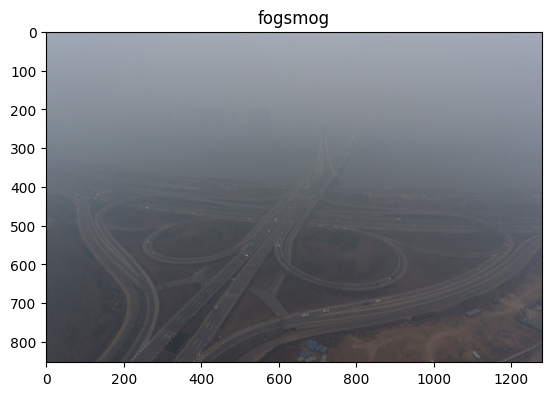

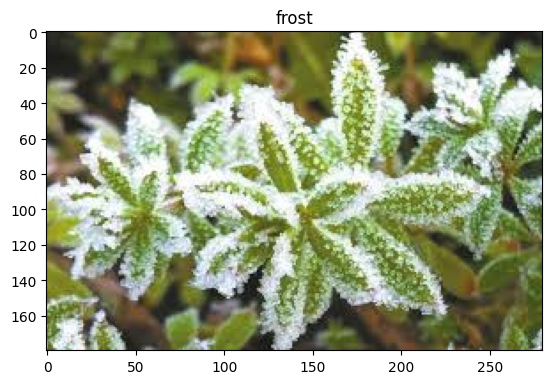

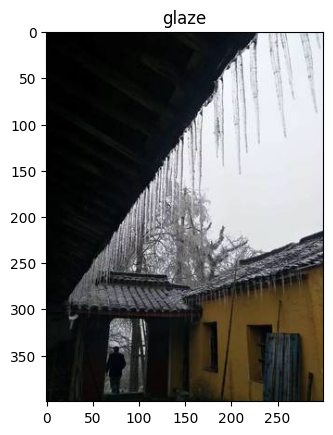

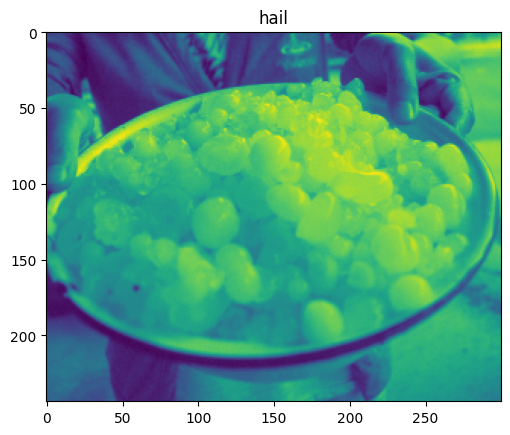

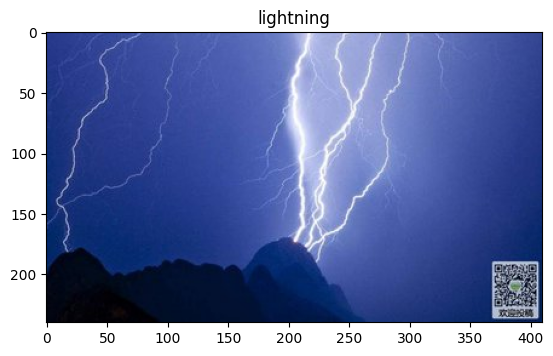

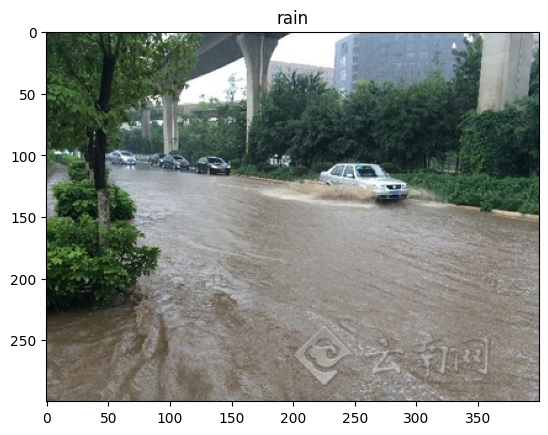

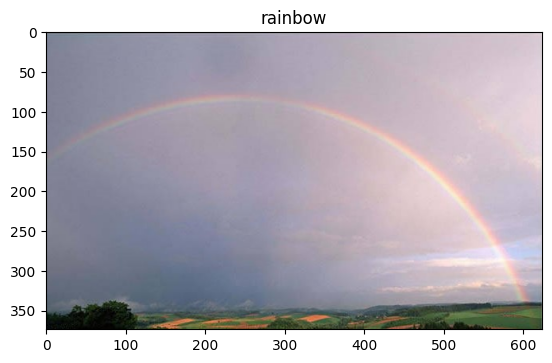

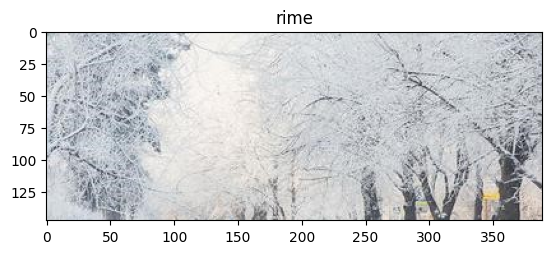

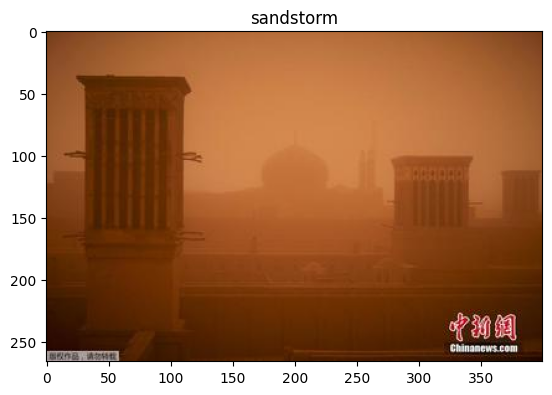

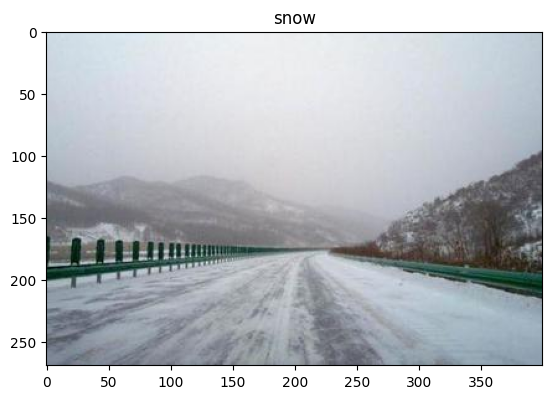

In [ ]:
#Visualize the first image of each class

for label_idx, class_name in classes.items():
  class_dir = os.path.join(root_dir, class_name)
  file_img = os.listdir(class_dir)[0]
  file_path = os.path.join(class_dir, file_img)
  img = Image.open(file_path)
  plt.imshow(img)
  plt.title(class_name)
  plt.show()

In [ ]:
img_paths = []
labels = []

for label_idx, class_name in classes.items():
  class_dir = os.path.join(root_dir, class_name)
  for file_img in os.listdir(class_dir):
    file_path = os.path.join(class_dir, file_img)
    img_paths.append(file_path)
    labels.append(label_idx)

##Split into train, val and test

In [ ]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state = seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state = seed,
    shuffle=is_shuffle
)

##Create custom Pytorch dataset

In [ ]:
class WeatherDataset(Dataset):
  def __init__(self, X, y, transforms = None):
    self.X = X
    self.y = y
    self.transforms = transforms

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    img_path = self.X[idx]
    img = Image.open(img_path).convert('RGB')
    label = self.y[idx]

    if self.transforms:
      img = self.transforms(img)

    return img, label

In [ ]:
def transform(img, img_size = (224, 224)):
  img = img.resize(img_size)
  img = np.array(img)[..., :3]
  img = torch.tensor(img).permute(2, 0, 1).float()
  normalized_img = img / 255.0
  return normalized_img

In [ ]:
train_dataset = WeatherDataset(X_train, y_train, transform)
val_dataset = WeatherDataset(X_val, y_val, transform)
test_dataset = WeatherDataset(X_test, y_test, transform)

##Create dataloader

In [ ]:
train_batch_size = 512
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = test_batch_size,
    shuffle=False
)

#Modeling

##Create residual block class

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride = 1):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_channels,
        out_channels,
        kernel_size = 3,
        stride = stride,
        padding = 1,
    )
    self.batch_norm1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(
        out_channels,
        out_channels,
        kernel_size = 3,
        stride = 1,
        padding = 1,
    )
    self.batch_norm2 = nn.BatchNorm2d(out_channels)

    self.downsample = nn.Sequential()

    if stride != 1 or in_channels != out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(
              in_channels,
              out_channels,
              kernel_size = 1,
              stride = stride,
          ),
          nn.BatchNorm2d(out_channels)
      )
    self.relu = nn.ReLU()

  def forward(self, x):
    shortcut = x.clone()
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.batch_norm2(x)
    x += self.downsample(shortcut)
    x = self.relu(x)

    return x

##Create model class

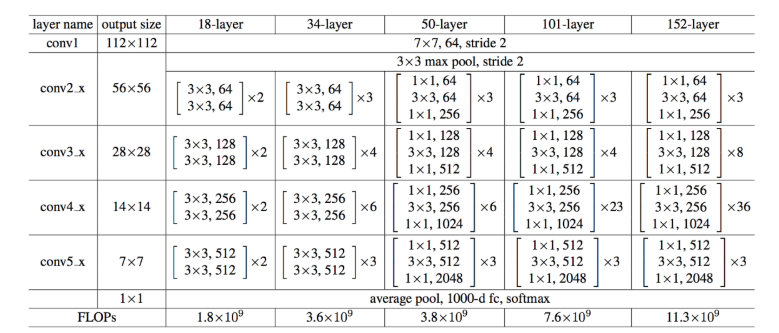

In [ ]:
class ResNet(nn.Module):
  def __init__(self, residual_block, n_blocks_lst, n_classes):
    super(ResNet, self).__init__()

    self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = 64,
        kernel_size = 7,
        stride = 2,
        padding = 3
    )
    self.batch_norm1 = nn.BatchNorm2d(64)
    self.max_pool = nn.MaxPool2d(
        kernel_size = 3,
        stride = 2,
        padding = 1
    )
    self.conv2 = self.create_layer(
        residual_block, 64, 64,
        n_blocks_lst[0], 1
    )
    self.conv3 = self.create_layer(
        residual_block, 64, 128,
        n_blocks_lst[1], 2
    )
    self.conv4 = self.create_layer(
        residual_block, 128, 256,
        n_blocks_lst[2], 2
    )
    self.conv5 = self.create_layer(
        residual_block, 256, 512,
        n_blocks_lst[3], 2
    )
    self.avg_pool = nn.AdaptiveAvgPool2d(1)
    self.relu = nn.ReLU()
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(512, n_classes)

  def create_layer(self, residual_block, in_channels,
                   out_channels, n_blocks, stride):
    blocks = []
    first_block = residual_block(in_channels, out_channels, stride)
    blocks.append(first_block)

    for i in range(1, n_blocks):
      block = residual_block(out_channels, out_channels, 1)
      blocks.append(block)

    block_sequential = nn.Sequential(*blocks)
    return block_sequential

  def forward(self, x):
    x = self.conv1(x)
    x = self.batch_norm1(x)
    x = self.max_pool(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)

    x = self.avg_pool(x)
    x = self.flatten(x)
    x = self.fc(x)

    return x

##Evaluate function

In [ ]:
def evaluate(model, data_loader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      losses.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  loss = np.mean(losses)
  accuracy = correct / total

  return loss, accuracy

##Training function

In [ ]:
def fit(model, train_loader, val_loader,
        criterion, optimizer, device, epochs):
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  for epoch in range(epochs):
    batch_train_losses = []
    correct = 0
    total = 0

    model.train()
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    train_loss = np.mean(batch_train_losses)
    train_losses.append(train_loss)
    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    val_loss, val_accuracy = evaluate(
        model, val_loader, criterion, device
    )
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print('*'*100)
    print(f'Epoch: {epoch+1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}')
    print('*'*100)

  return train_losses, val_losses, train_accuracies, val_accuracies

##Create model

In [ ]:
n_classes = len(list(classes.keys()))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = ResNet(
    ResidualBlock,
    [2, 2, 2, 2],
    n_classes
).to(device)

device

'cuda'

In [ ]:
lr = 1e-2
epochs = 25

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

##Training

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = fit(
    model, train_loader, val_loader,
    criterion, optimizer, device, epochs
)

****************************************************************************************************
Epoch: 1/25
Train Loss: 3.0125 | Train Accuracy: 0.2005
Val Loss: 29915.0468 | Val Accuracy: 0.0554
****************************************************************************************************
****************************************************************************************************
Epoch: 2/25
Train Loss: 1.9919 | Train Accuracy: 0.3615
Val Loss: 107.0950 | Val Accuracy: 0.1413
****************************************************************************************************
****************************************************************************************************
Epoch: 3/25
Train Loss: 1.7475 | Train Accuracy: 0.4304
Val Loss: 19.2345 | Val Accuracy: 0.2527
****************************************************************************************************
***************************************************************************************************

##Visualize

In [ ]:
#Set the maximum values of val_losses as 3.0

modified_val_losses = [min(val_loss, 3.0) for val_loss in val_losses]

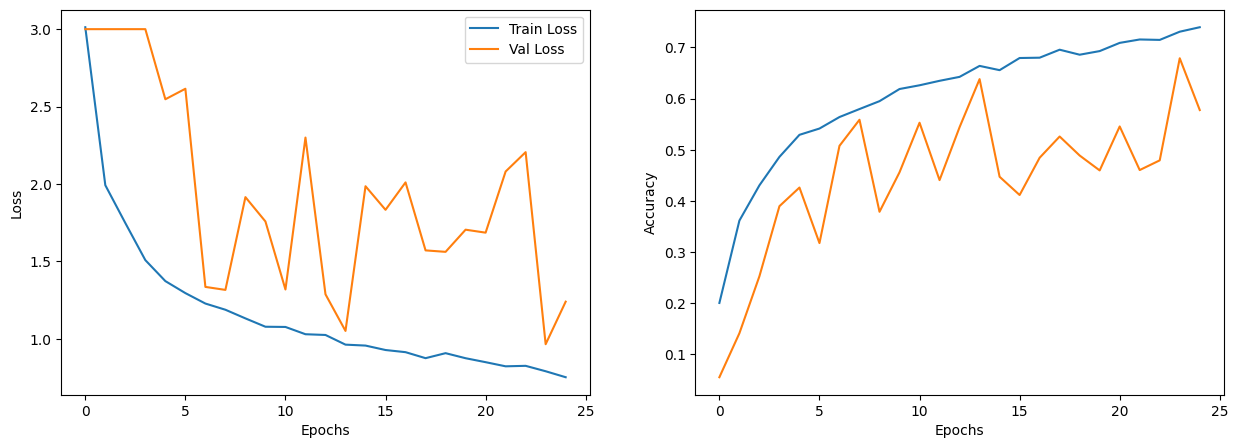

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(train_losses, label='Train Loss')
ax[0].plot(modified_val_losses, label='Val Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(train_accuracies, label='Train Accuracy')
ax[1].plot(val_accuracies, label='Val Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend

plt.show()